# Reducing the Correlated Noise of JPL PPL Data using SIRS

Bernard.J.Rauscher@nasa.gov<br>
9 June 2021

## 1. Introduction

This notebook revisits our earlier analysis of the JPL PPL detector. It turns out that this specific detector has some bad reference rows in the right hand reference columns. Try interpolating over them to see if this improves things.

The real fix would be to delete these pixels from the incomplete Fourier transform. But, that would require more extensive code modifications than are warranted for this one detector.

In [1]:
# Standard imports
using Revise        # Handy for interactive work
using Glob          # Filename globbing
using FITSIO        # Julia's standard FITS package
using Jacobi        # Legendre polynomials defined here
using LinearAlgebra # Moore-Penrose inverse is here
using OMEinsum      # Tensor operations
using StatsBase     # Robuts statistics
using Plots         # Plotting

# Simple Improved Reference Subtraction (SIRS)
using SIRS

┌ Info: Precompiling SIRS [40ae95f3-0455-409b-a0fb-071cca222575]
└ @ Base loading.jl:1278


In [2]:
# The data are here on ADAPT
ddir = "/att/gpfsfs/briskfs01/ppl/cshapiro/JPL-PPL/H4RG-18241/2021-04-15"

# Put the results here
rdir = "/att/gpfsfs/briskfs01/ppl/brausche/roman_caldir/JPL_PPL_Results2/";

In [3]:
# Get a list of the input files
files = glob("*.fits", ddir);
# files = files[1:2]; # STUB - Do just a few to speed things up

In [4]:
# Instantiate a SIRSCore. From looking at the FITS headers, I know that
# all files have 60 frames sampled up-the-ramp.
#
# According to Chaz Shapiro, the new row overhead (nroh)
# is different from in DCL data. According to Chaz, it is 26.48 µs.
# SIRS assumes that it is an integral number of pixel readout times.
# We will see how that imprints today. For now, say nroh = 5 pixels.
#
# PPL parameters as follows.
hxrg_kind = "h4rg" # Type of HxRG
nout      = 32     # Number of outputs
nroh      = 5      # See above
τ         = 5.e-6  # 200 kHz clocking
naxis3    = 59     # Chaz says to discard the first frame
sc = SIRSCore(hxrg_kind, nout, nroh, τ, naxis3); # Discard 1st frame!

In [5]:
# Solve for the frequency dependent weights.
#
# This cell can be very time consuming. The execution time on
# Prism with 40 cores enabled is about 65 seconds/file.

for file in files
    
    # Show some status
    println("Processing file: ", file)
   
    # These are JPL PPL data. The format is a single datacube.
    # Like in the DCL, charge seems to integrate down. For now,
    # just leave this. 
    f = FITS(file, "r")
    D = Float64.(read(f[1]))
    close(f)
    
    # Consider dropping frame #1 before coadd. Chaz says that the
    # system is unstable.
    D = D[:,:,2:end]
    
    # Coadd
    coadd!(sc, D)

end

Processing file: /att/gpfsfs/briskfs01/ppl/cshapiro/JPL-PPL/H4RG-18241/2021-04-15/PPL_longdark_0000.fits
Processing file: /att/gpfsfs/briskfs01/ppl/cshapiro/JPL-PPL/H4RG-18241/2021-04-15/PPL_longdark_0001.fits
Processing file: /att/gpfsfs/briskfs01/ppl/cshapiro/JPL-PPL/H4RG-18241/2021-04-15/PPL_longdark_0002.fits
Processing file: /att/gpfsfs/briskfs01/ppl/cshapiro/JPL-PPL/H4RG-18241/2021-04-15/PPL_longdark_0003.fits
Processing file: /att/gpfsfs/briskfs01/ppl/cshapiro/JPL-PPL/H4RG-18241/2021-04-15/PPL_longdark_0004.fits
Processing file: /att/gpfsfs/briskfs01/ppl/cshapiro/JPL-PPL/H4RG-18241/2021-04-15/PPL_longdark_0005.fits
Processing file: /att/gpfsfs/briskfs01/ppl/cshapiro/JPL-PPL/H4RG-18241/2021-04-15/PPL_longdark_0006.fits
Processing file: /att/gpfsfs/briskfs01/ppl/cshapiro/JPL-PPL/H4RG-18241/2021-04-15/PPL_longdark_0007.fits
Processing file: /att/gpfsfs/briskfs01/ppl/cshapiro/JPL-PPL/H4RG-18241/2021-04-15/PPL_longdark_0008.fits
Processing file: /att/gpfsfs/briskfs01/ppl/cshapiro/JPL

In [6]:
# Solve for the frequency dependent weights, alpha and beta
solve!(sc);

In [7]:
# Save results
output_filename = rdir*"2021-06-09T10:05:00_PPL_18241_95.0K_-1.0V_SIRS.jld"
SIRS.save(sc, output_filename)

In [8]:
# sc = restore(rdir*"2021-04-21T06:57:06_PPL_18241_95.0K_-1.0V_SIRS.jld");

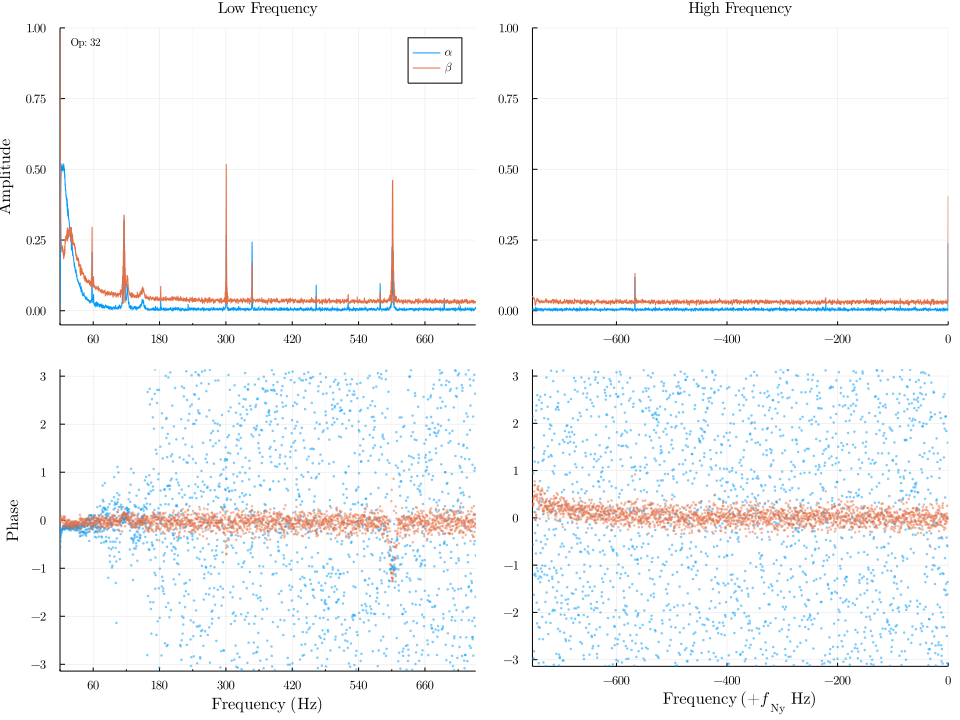

In [12]:
op16 = wplot(sc, 32, mag=1.5, nice=true)